In [33]:
import numpy as np
from scipy.ndimage import filters
from PIL import Image
import imutils
import matplotlib.pylab as plt

In [34]:
# Get gaussian filters.
def Harris_Matrix(image, sigma = 2): #sigma is always 2
    Lx = np.zeros(image.shape)
    filters.gaussian_filter(image, 1, (0,1), output = Lx)
    Ly = np.zeros(image.shape)
    filters.gaussian_filter(image, 1, (1,0), output = Ly)
    
    # Compute the components of the Harris matrix - used to find Trace and Determinant below
    A = filters.gaussian_filter(Lx * Lx, sigma)
    B = filters.gaussian_filter(Lx * Ly, sigma)
    C = filters.gaussian_filter(Ly * Ly, sigma)
    
    # Find the Trace and Detminant - used to calculate R
    determinantM = (A * C) - (B ** 2)
    traceM = (A + C)
    
    return determinantM / traceM


In [35]:
# Find Harris corner points above a threshold and perform nonmax suppression in the region +/- minimumDistance.
def Get_Harris_Points(Harris_image):
    # Define a minimum distance between the points
    Minimum_distance = 10
    # Define a threshold to filte the points below 0.9 max value
    threshold = 0.1
    
    # To get top points above a threshold(0.9) times max value
    cornerThreshold = Harris_image.max() * threshold
    Image_thresholded = (Harris_image > cornerThreshold)
    
    # Convert list value into array and delete all nonzero value
    # Return the location(position) of the Harri points in orihinal image 
    coordinates = np.array(Image_thresholded.nonzero()).T
    candidateValues = np.array([Harris_image[c[0],c[1]] for c in coordinates])
    
    # Return the indeces and sort array as increasing order
    indices = np.argsort(candidateValues)
    
    # Store the allowed point locations in a Boolean Image and guarantee the the minmum distance of a points and reduce the nonmax
    # value effect
    Pure_locations = np.zeros(Harris_image.shape, dtype = 'bool')
    Pure_locations[Minimum_distance:-Minimum_distance, Minimum_distance:-Minimum_distance] = True
    
    # Select the best points using nonmax suppression based on the allowedLocations array
    filteredCoordinates = []
    for i in indices[::-1]:
        r, c = coordinates[i]
        if Pure_locations[r, c]:
            filteredCoordinates.append((r, c))
            Pure_locations[r-Minimum_distance:r+Minimum_distance, c-Minimum_distance:c+Minimum_distance] = False
            
    return filteredCoordinates


In [36]:
# Plot all red Harris interesting points
def Plot_Harris_Interest_Points(image, interestPoints):
    plt.figure('Harris points/corners')
    plt.imshow(image, cmap='gray')
    plt.plot([p[1] for p in interestPoints], [p[0] for p in interestPoints], 'ro')
    plt.axis('off')
    plt.show() 

Images shown:


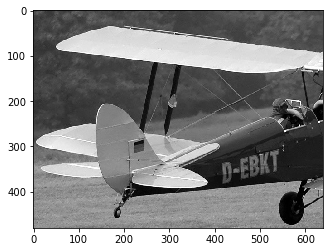

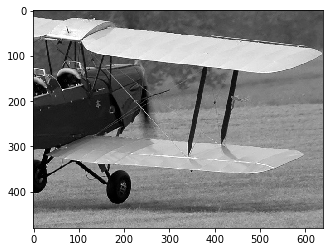

Harris interesting points:
Shown printing Harris interesting points:


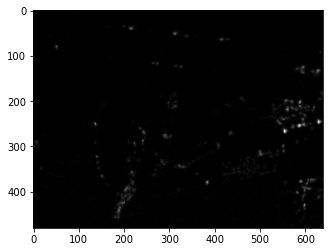

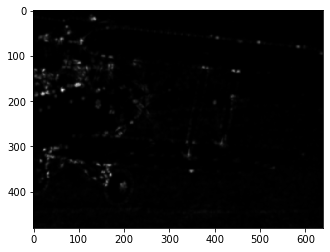

Getting Interest Points for both images
Found 79 interest points in image 1.
Found 101 interest points in image 2.


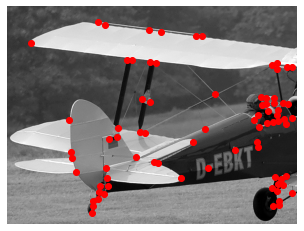

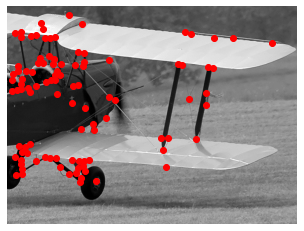

In [42]:
# Reading Images from memory.           
harrisImage1 = (np.array(Image.open('image-pairs/tigermoth1.png').convert('L'), dtype=np.float32))
harrisImage2 = (np.array(Image.open('image-pairs/tigermoth2.png').convert('L'), dtype=np.float32))

# Shown the images in memeory.
print("Images shown:")
imutils.imshow(harrisImage1)
imutils.imshow(harrisImage2)

# Use the threshold to generate filter and store the bright points 
print("Harris interesting points:")
image1 = Harris_Matrix(harrisImage1, 2)
image2 = Harris_Matrix(harrisImage2, 2)

# Show the gray interesting points
print("Shown printing Harris interesting points:")
imutils.imshow(image1)
imutils.imshow(image2)

# Make the bright points into red
print("Getting Interest Points for both images")
interestPoints1 = Get_Harris_Points(image1)
interestPoints2 = Get_Harris_Points(image2)

# Use the interesting points length to get the points number 
print("Found " + str(len(interestPoints1)) +  " interest points in image 1.")
print("Found " + str(len(interestPoints2)) +  " interest points in image 2.")

# Show the red interesting points in images
Plot_Harris_Interest_Points(harrisImage1, interestPoints1)
Plot_Harris_Interest_Points(harrisImage2, interestPoints2)

In [43]:
# Convert all points into vectors.
def Vectors_Descriptors(image, interestPoints):
    # Define a width to frame a small region
    width = 5
    # Define a descriptor to store all interesting points
    descriptors = []
    
    # Use the width return a small region and store it in list
    # Normalize all vector points
    for point in interestPoints:
        vector = image[point[0] - width:point[0] + width + 1,point[1] - width:point[1] + width + 1].flatten()
        vector -= np.mean(vector)
        vector /= np.linalg.norm(vector)
        descriptors.append(vector)
    
    return descriptors

In [44]:
# Match all points in both pictures.
def Match_Descriptors(descriptors1, descriptors2):
    # Set a 0.95 threshold to filte most of useless points
    threshold = 0.95
    
    # Define 2 array to store 2 insteresting regions
    descriptors1 = np.array(descriptors1).astype('float32')
    descriptors2 = np.array(descriptors2).astype('float32')
    
    # Calculate the dot of two descript array.
    # Find the maximum values of array1, array2 and the dot product
    Response_matrix = np.dot(descriptors1, descriptors2.T)
    max1 = descriptors1.max()
    max2 = descriptors2.max()
    Max_elem_martix = Response_matrix.max()
    
    # Initial, non-thresholded dot product - compared with the thresholded version below
    originalMatrix = Image.fromarray(Response_matrix * 255)
    
    # Setting a pair array and stores all matrix position
    Points_pairs = []
    for r in range(Response_matrix.shape[0]):
        First_colum_value = Response_matrix[r, 0]
        for c in range(Response_matrix.shape[1]):
            if (Response_matrix[r, c] > threshold) and (Response_matrix [r, c] > First_colum_value):
                Points_pairs.append((r,c))
            else:
                Response_matrix[r, c] = 0
                
    # Compare the above matrix with the new, thresholded matrix    
    Thresholded_matrix = Image.fromarray(Response_matrix * 255)
    
    # In order: Maximum of array1, maximum of array2, maximum of Dot Product,
    # Image before thresholding, Image after thresholding and Pairs list
    return max1, max2, Max_elem_martix, originalMatrix, Thresholded_matrix, Points_pairs

In [45]:
# Plot all points and lines
def Plot_Matches(image1, image2, interestPoints1, interestPoints2, pairs):
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    if rows1 < rows2:
        image1 = np.concatenate((image1, np.zeros((rows2 - rows1, image1.shape[1]))), axis=0)
    elif rows2 < rows1:
        image2 = np.concatenate((image2, np.zeros((rows1 - rows2, image2.shape[1]))), axis=0)

    # create new image with two input images appended side-by-side, then plot matches
    image3 = np.concatenate((image1, image2), axis=1)


    # note outliers in this image - RANSAC will remove these later
    plt.imshow(image3, cmap="gray")
    column1 = image1.shape[1]

    # plot each line using the indexes recovered from pairs
    for index in range(len(pairs)):
        index1, index2 = pairs[index]
        plt.scatter([interestPoints1[index1][1], interestPoints2[index2][1] + column1],
                 [interestPoints1[index1][0], interestPoints2[index2][0]], color = 'r', s = 2)
        plt.plot([interestPoints1[index1][1], interestPoints2[index2][1] + column1],
                 [interestPoints1[index1][0], interestPoints2[index2][0]], color = 'g', linewidth = 0.5)
    plt.axis('off')
    plt.show()

Maximum of Image1: 0.54206336
Maximum of Image2: 0.54206336
Maximum of Dot Product: 1.0000004

Response matrix before and after thresholding: 


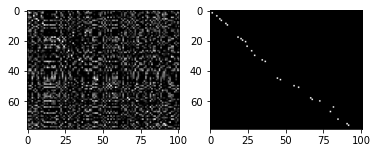


Plot the matches between the two images:


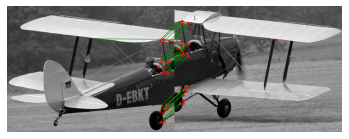

In [46]:
# Use to get Normalised Image Patches (Image Descriptors) for both images
descriptors1 = Vectors_Descriptors(harrisImage1, interestPoints1)
descriptors2 = Vectors_Descriptors(harrisImage2, interestPoints2)

# Use to matches between Descriptors
Maxvalue_image1, Maxvalue_image2, Max_dotproduct, Original_matrix, Thresholded_matrix, Pairs_list = Match_Descriptors(descriptors1, descriptors2)
# Output the maximum value of images
print("Maximum of Image1: " + str(Maxvalue_image1))
print("Maximum of Image2: " + str(Maxvalue_image2))
print("Maximum of Dot Product: " + str(Max_dotproduct))

# Print the response matrix binary image
print("\nResponse matrix before and after thresholding: ")
plt.subplot(121)
plt.imshow(Original_matrix)
plt.subplot(122)
plt.plot([0,])
plt.imshow(Thresholded_matrix)
plt.show()

# Output the match image
print("\nPlot the matches between the two images:")
result = Plot_Matches(harrisImage1, harrisImage2, interestPoints1, interestPoints2, Pairs_list)


In [30]:
# To Get the offset to conbine pictures
def RANSAC(matches, coordinates1, coordinates2 ):
    # Define a distance as a condition to judgement distance and jusify the offset
    matchDistance=1.6
    d2 = matchDistance ** 2
    
    # Build a list of offsets from the lists of matching points for the 2 images.
    # Use two array to store 2 offset in colum and row.
    offsets = np.zeros((len(matches), 2))
    for i in range(len(matches)):
        index1, index2 = matches[i]
        offsets[i, 0] = coordinates1[index1][0] - coordinates2[index2][0]
        offsets[i, 1] = coordinates1[index1][1] - coordinates2[index2][1]
     
    # Use the for loop to clean noise and comparison each pairs offset and return a average offset.
    # If the images are parallel, The offset of each pair are similar, so the offset will be strongly useful.
    # Sometimes, If the images is rotated and scalared, the offset maybe fail.
    # Run the comparison.  best_match_count keeps track of the size of the
    # largest consensus set, and (best_row_offset,best_col_offset) the
    # current offset associated with the largest consensus set found so far.
    best_match_count = -1
    best_row_offset, best_col_offset = 1e6, 1e6
    for i in range(len(offsets)):
        match_count = 1.0
        offi0 = offsets[i, 0]
        offi1 = offsets[i, 1]
        # Use j loop looking for consensus if this point hasn't
        # been found and folded into a consensus set earlier.  Just improves
        # efficiency.
        if (offi0 - best_row_offset) ** 2 + (offi1 - best_col_offset) ** 2 >= d2:
            sum_row_offsets, sum_col_offsets = offi0, offi1
            for j in range(len(matches)):
                if j != i:
                    offj0 = offsets[j, 0]
                    offj1 = offsets[j, 1]
                    if (offi0 - offj0) ** 2 + (offi1 - offj1) ** 2 < d2:
                        sum_row_offsets += offj0
                        sum_col_offsets += offj1
                        match_count += 1.0
            if match_count >= best_match_count:
                best_row_offset = sum_row_offsets / match_count
                best_col_offset = sum_col_offsets / match_count
                best_match_count = match_count
                
    return best_row_offset, best_col_offset, best_match_count


In [31]:
# Conbine 2 pictures
def Append_Images(image1, image2, rowOffset, columnOffset):
    # Convert floats to ints
    rowOffset = int(rowOffset)
    columnOffset = int(columnOffset)
    
    # create new 'canvas' image with calculated dimensions
    canvas = Image.new(image1.mode, (image1.width + abs(columnOffset), image1.width + abs(
        rowOffset)))  
    canvas.paste(image1, (0, canvas.height - image1.height))  # paste image1
    canvas.paste(image2, (columnOffset, canvas.height - image1.height + rowOffset))  # paste image2

    # plot final composite image
    plt.figure('Final Composite Image')
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()
    
    return canvas


Number of agreements (best match count): 19.0
Row offset: -219.0
Column offset: 293.0
Final Image Reconstruction:


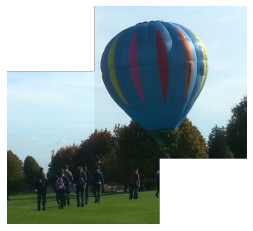

In [32]:
# Output the images aligmnet
# Use RANSAC to clean the noise
rowOffset, columnOffset, bestMatches = RANSAC(Pairs_list, interestPoints1, interestPoints2)
print('Number of agreements (best match count): ' + str(bestMatches))
print('Row offset: ' + str(rowOffset))
print('Column offset: ' + str(columnOffset))

print("Final Image Reconstruction:")
colourImage1 = Image.open('image-pairs/balloon1.png')
colourImage2 = Image.open('image-pairs/balloon2.png')
final = Append_Images(colourImage1, colourImage2, rowOffset, columnOffset)